Best PNorm MSE for WS: 0.4642, Features: F22, F31, F43
Best NNOrm MSE for WS: 0.2627, Features: F22, F24, F31, F43
Best Norm MSE for WS: 0.5250, Features: F22, F24, F31, F43
Ensemble NNorm MSE for WS: 0.3190, Features: F22, F24, F31, F43
Ensemble Normd MSE for WS: 0.6421, Features: F22, F24, F31, F43
Ensemble PNorm MSE for WS: 0.4695, Features: F22, F24, F31, F43
Best PNorm MSE for NR: 0.7361, Features: F24, F43, F44, F45
Best NNOrm MSE for NR: 0.2786, Features: F24, F43, F44, F45
Best Norm MSE for NR: 0.5506, Features: F24, F43, F44, F45
Ensemble NNorm MSE for NR: 0.3321, Features: F24, F43, F44, F45
Ensemble Normd MSE for NR: 0.6692, Features: F24, F43, F44, F45
Ensemble PNorm MSE for NR: 0.8996, Features: F24, F43, F44, F45, F46
Best PNorm MSE for PR: 0.5237, Features: F43, F44, F45, Federal_Class
Best NNOrm MSE for PR: 0.3721, Features: F43, F44, F45
Best Norm MSE for PR: 0.5917, Features: F43, F44, F45
Ensemble NNorm MSE for PR: 0.3807, Features: F43, F44, F45
Ensemble Normd MSE f

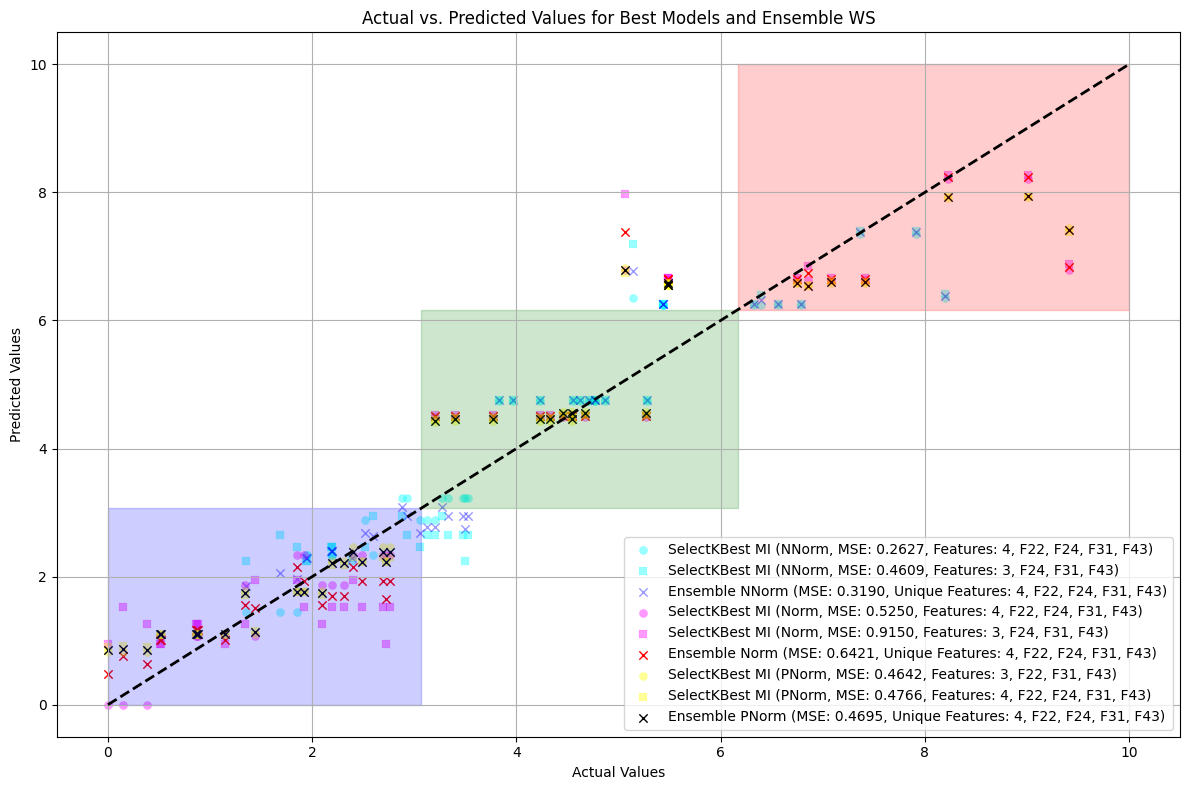

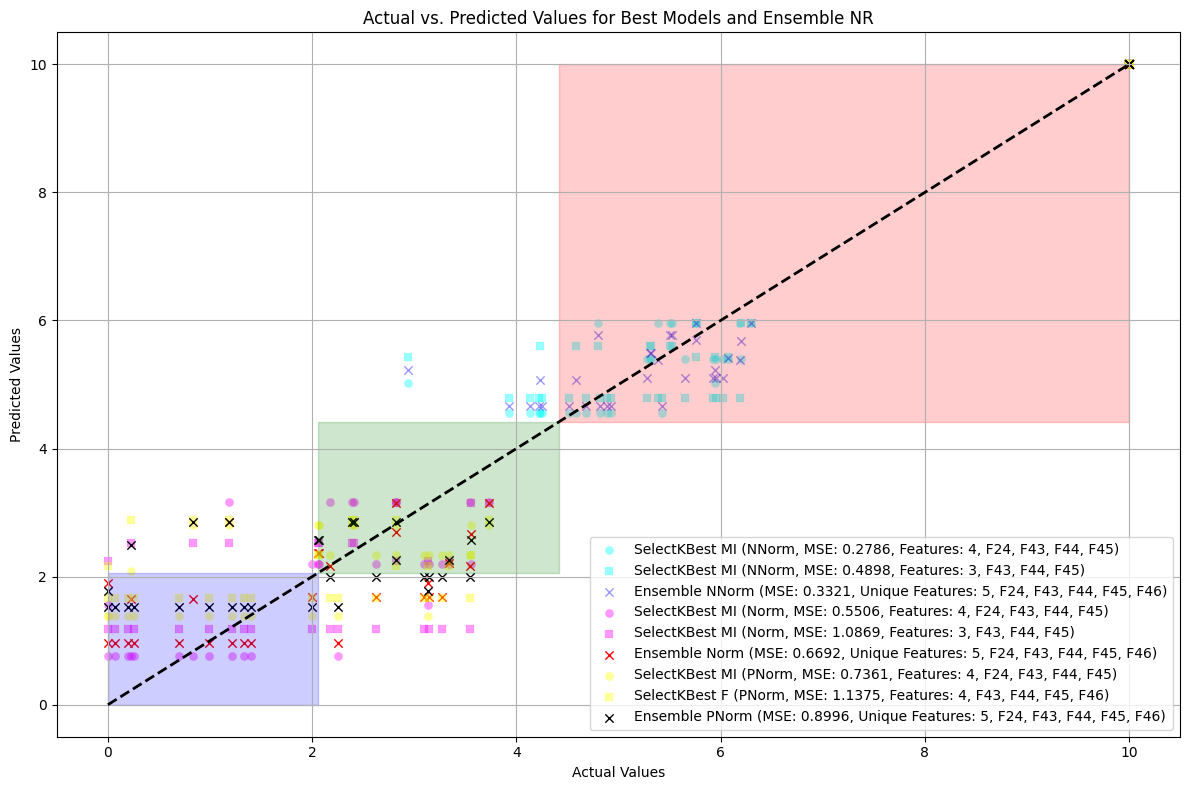

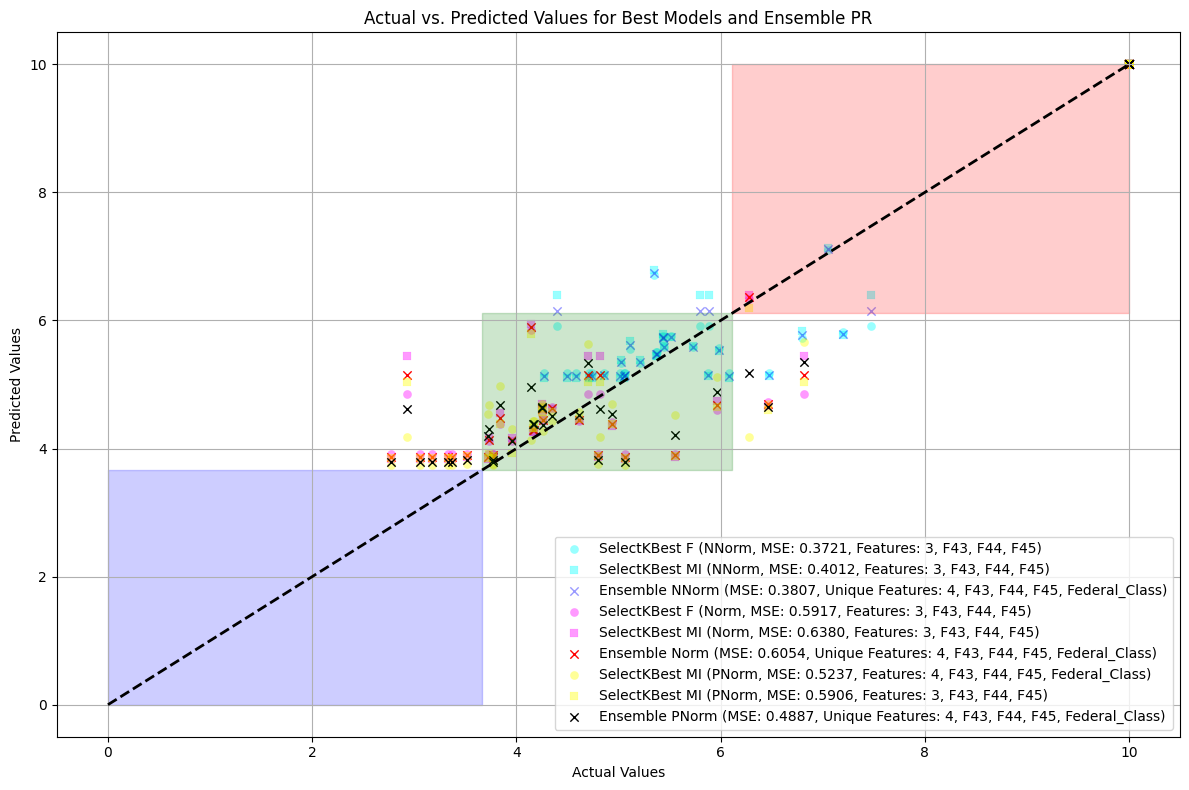

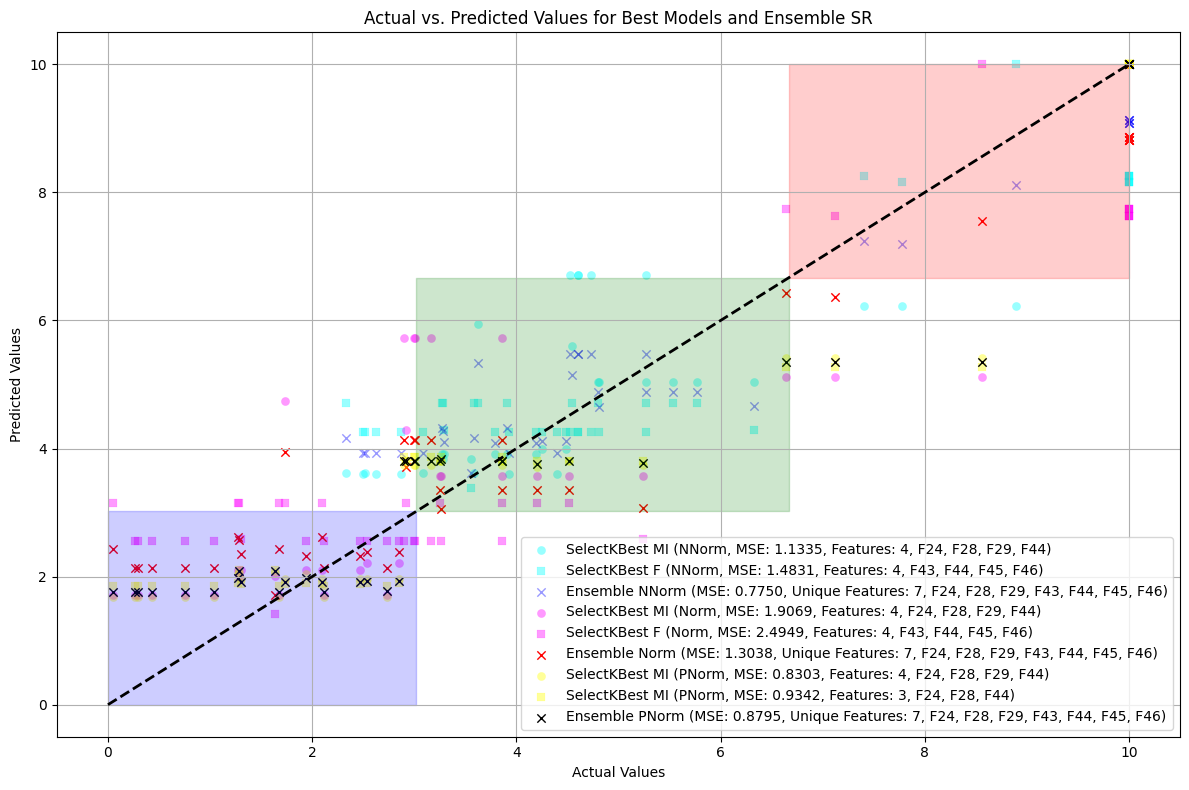

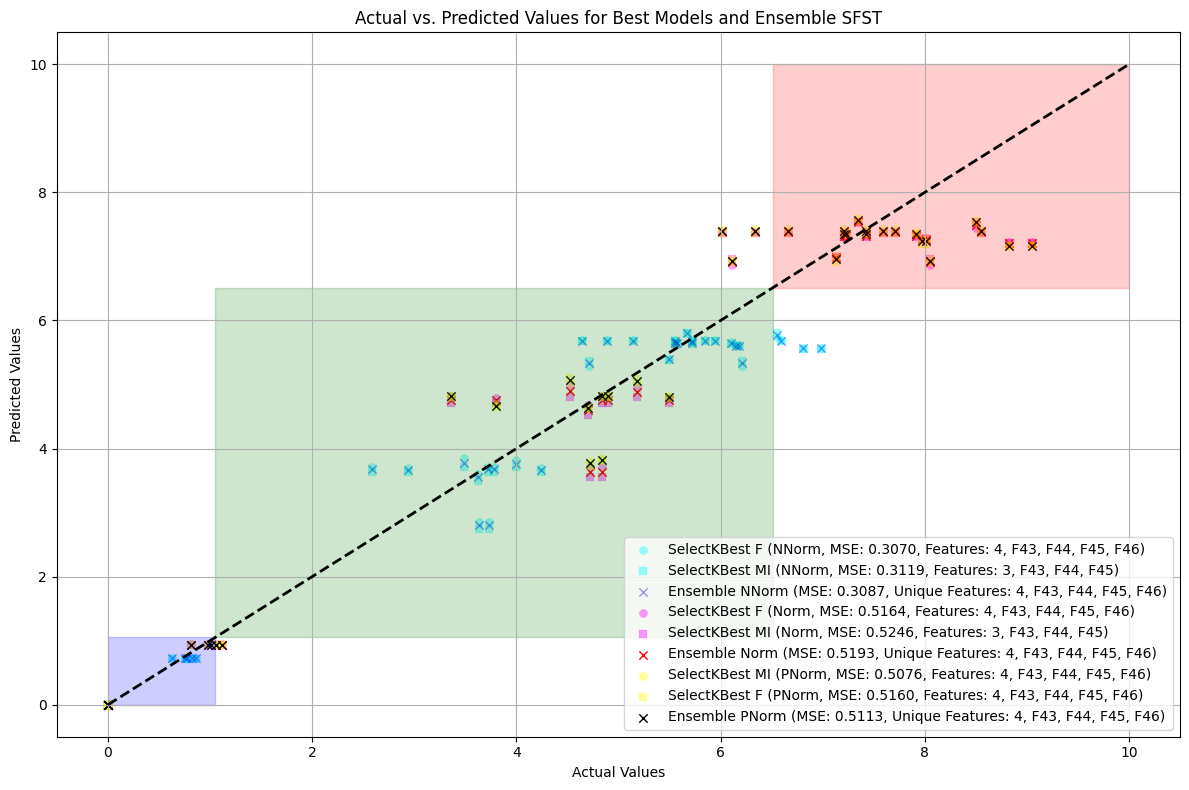

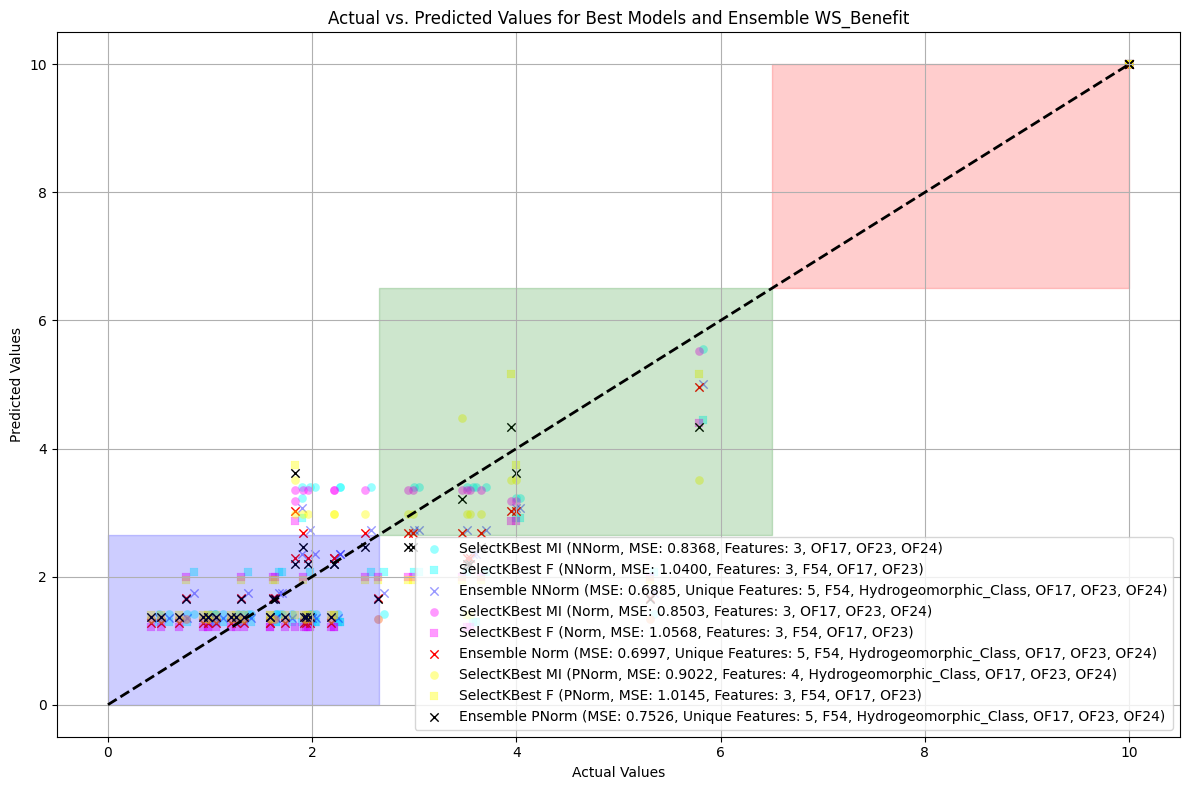

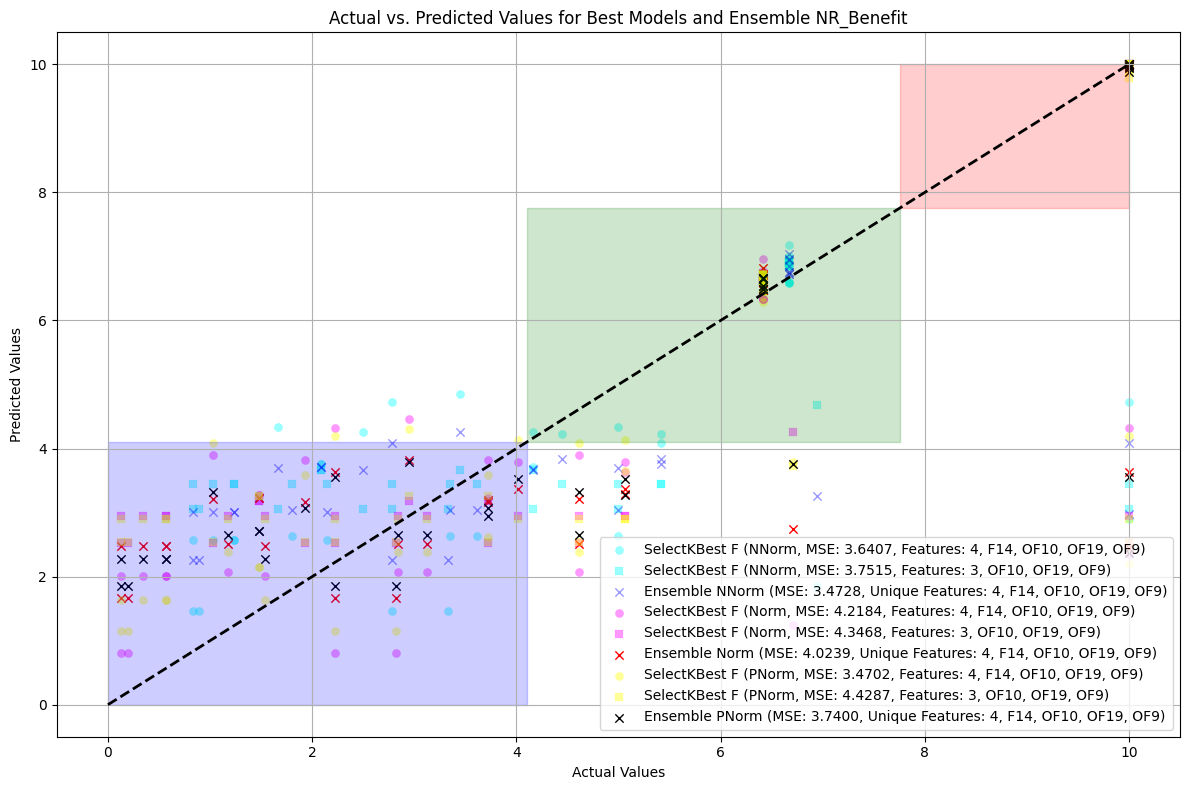

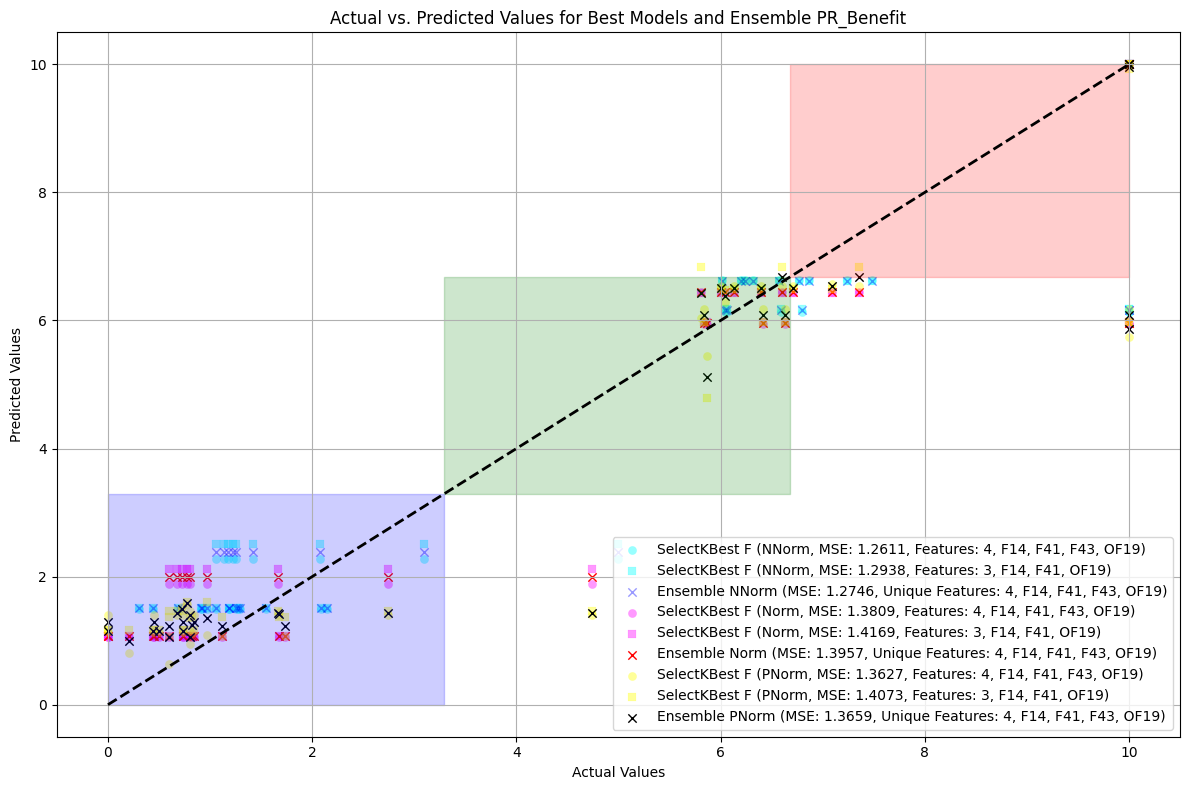

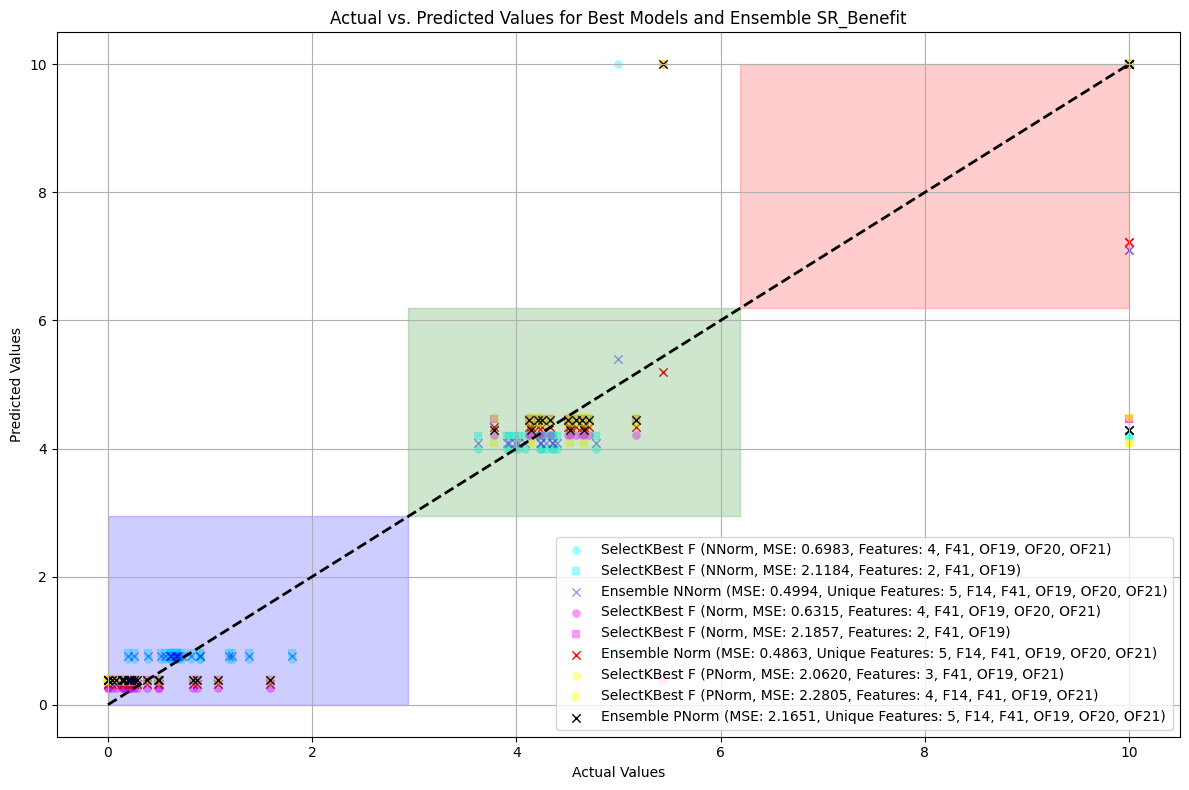

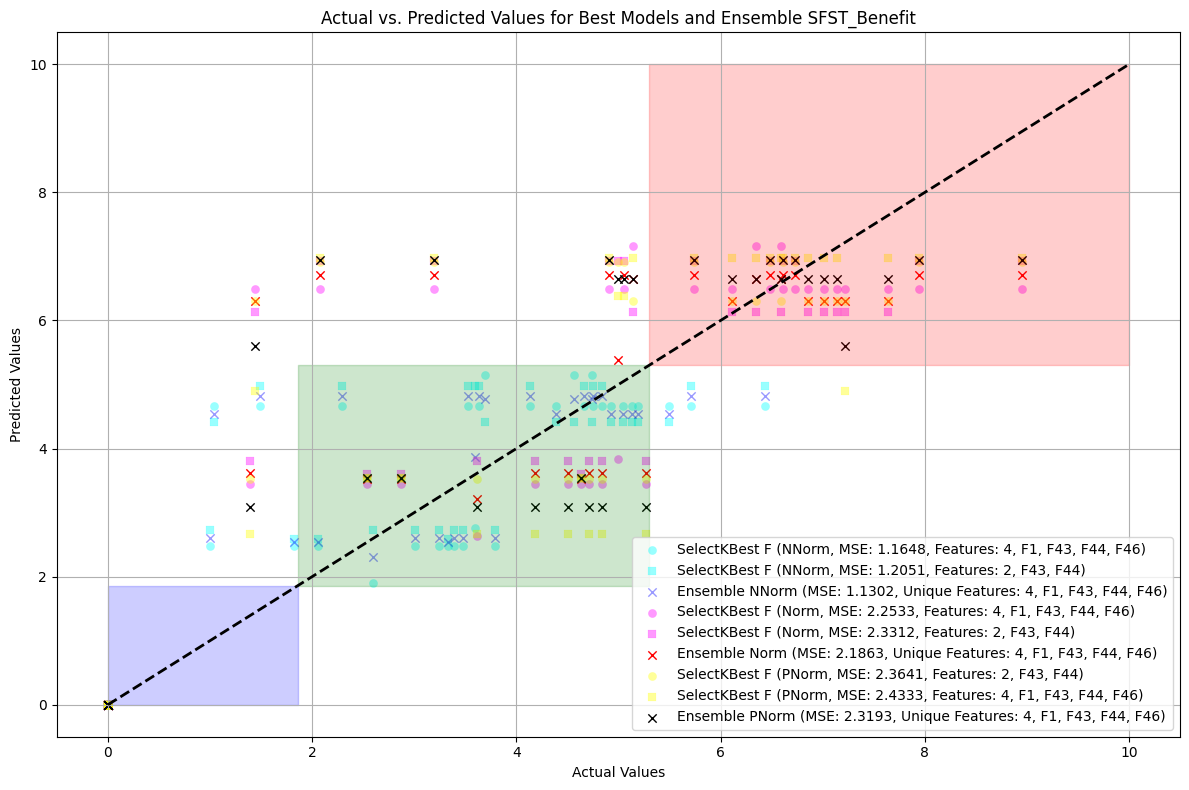

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import os
from sklearn.metrics import mean_squared_error

# Configuration for all functions
config = {
    "WS": {"min": 1.58, "max": 8.61, "lower": 3.07, "higher": 6.17},
    "PR": {"min": 2.07, "max": 10.0, "lower": 3.66, "higher": 6.11},
    "NR": {"min": 4.10, "max": 10.0, "lower": 2.06, "higher": 4.42},
    "SR": {"min": 2.29, "max": 10.0, "lower": 3.02, "higher": 6.67},
    "SFST": {"min": 0.0, "max": 7.71, "lower": 1.05, "higher": 6.51},
    "WS_Benefit": {"min": 0.08, "max": 10.0, "lower": 2.65, "higher": 6.50},
    "PR_Benefit": {"min": 0.49, "max": 10.0, "lower": 3.29, "higher": 6.68},
    "NR_Benefit": {"min": 0.71, "max": 10.0, "lower": 4.10, "higher": 7.76},
    "SR_Benefit": {"min": 0.49, "max": 8.79, "lower": 2.94, "higher": 6.19},
    "SFST_Benefit": {"min": 0.0, "max": 7.19, "lower": 1.86, "higher": 5.30}
}

# Function to normalize the predictions
def normalize_predictions(predicted, actual, feature):
    min_val = config[feature]["min"]
    max_val = config[feature]["max"]
    return np.clip((predicted - min_val) / (max_val - min_val) * 10, 0, 10), np.clip((actual - min_val) / (max_val - min_val) * 10, 0, 10)

# Number of top models to display in the legend
top_n_models = 2

# List of features to process
result_columns_list = ['WS', 'NR', 'PR', 'SR', 'SFST', 'WS_Benefit', 'NR_Benefit', 'PR_Benefit', 'SR_Benefit', 'SFST_Benefit']

# Mapping for technique names to their shorter versions
technique_name_map = {
    "SelectKBest_f_regression": "SelectKBest F",
    "SelectKBest_mutual_info_regression": "SelectKBest MI",
    "VarianceThreshold": "VarianceThreshold"
}

for g in range(len(result_columns_list)):
    TITLE = result_columns_list[g]
    params = config[TITLE]
    
    all_results = []

    for norm_type in ['non_norm', 'norm']:
        test_results_path = f"./test_results_{TITLE}_{norm_type}.csv"
        if not os.path.exists(test_results_path):
            continue

        test_results_df = pd.read_csv(test_results_path)
    
        # List of feature selection techniques
        feature_selection_techniques = [
            "SelectKBest_f_regression",
            "SelectKBest_mutual_info_regression",
            "VarianceThreshold"
        ]
    
        # Iterate over each feature selection technique
        for technique in feature_selection_techniques:
            # Filter results for the current technique
            technique_results = test_results_df[test_results_df['Selection Method'] == technique]
    
            # Select results with fewer than or equal to 5 features
            technique_results = technique_results[technique_results['Number of Features'] <= 4]
    
            # Add the results to the list
            for idx, row in technique_results.iterrows():
                # Extract actual and predicted values
                actual_values = np.array(ast.literal_eval(row['Actual']))  # Convert to numpy array
                predicted_values = np.array(ast.literal_eval(row['Predicted']))  # Convert to numpy array
                
                # Normalize the values only for the 'Norm' plots
                predicted_values_norm, actual_values_norm = None, None
                if norm_type == 'non_norm':
                    predicted_values_norm, actual_values_norm = normalize_predictions(predicted_values, actual_values, TITLE)
                
                features = ast.literal_eval(row['Selected Features'])
                num_features = len(features)
    
                # Sort and format features list
                sorted_features = ', '.join(sorted(map(str, features))).replace("'", "")
                
                all_results.append({
                    'Technique': technique_name_map.get(technique, technique),  # Use the shortened name
                    'MSE': row['MSE'],  # Using MSE instead of RMSE
                    'Actual': actual_values,
                    'Predicted': predicted_values,
                    'Actual_Norm' :actual_values_norm,
                    'Predicted_Norm' : predicted_values_norm,
                    'Features': sorted_features,
                    'Number of Features': num_features,
                    'Norm Type': norm_type
                })
    
    # Separate all results into norm and non-norm lists
    norm_results = sorted([result for result in all_results if result['Norm Type'] == 'norm'], key=lambda x: x['MSE'])[:top_n_models]
    non_norm_results = sorted([result for result in all_results if result['Norm Type'] == 'non_norm'], key=lambda x: x['MSE'])[:top_n_models]
    
    # Print the best (lowest) MSE for norm, non-norm, and non-norm-normalized data
    if norm_results:
        best_norm_result = norm_results[0]
        print(f"Best PNorm MSE for {TITLE}: {best_norm_result['MSE']:.4f}, Features: {best_norm_result['Features']}")
    
    if non_norm_results:
        best_non_norm_result = non_norm_results[0]
        print(f"Best NNOrm MSE for {TITLE}: {best_non_norm_result['MSE']:.4f}, Features: {best_non_norm_result['Features']}")
    
    if non_norm_results:
        best_non_norm_norm_result = sorted(non_norm_results, key=lambda x: mean_squared_error(x['Actual_Norm'], x['Predicted_Norm']))[0]
        print(f"Best Norm MSE for {TITLE}: {mean_squared_error(best_non_norm_norm_result['Actual_Norm'], best_non_norm_norm_result['Predicted_Norm']):.4f}, Features: {best_non_norm_norm_result['Features']}")
    
    # Set to store features from the top models
    top_features = set()
    for result in norm_results + non_norm_results:
        top_features.update(result['Features'].split(', '))
    
    # Colors and markers for the selected models
    colors = {
        'non_norm': ['cyan'] * top_n_models,
        'norm_by_code': ['magenta'] * top_n_models,
        'norm': ['yellow'] * top_n_models
    }
    markers = ['o', 's', '^']
    
    # Plot the actual vs. predicted values for the best cases
    plt.figure(figsize=(12, 8))

    # Plot the non-norm models first (raw non-normalized)
    for idx, result in enumerate(non_norm_results):
        plt.scatter(result['Actual'], result['Predicted'],
                    label=f"{result['Technique']} (NNorm, MSE: {result['MSE']:.4f}, Features: {result['Number of Features']}, {result['Features']})",
                    color=colors['non_norm'][idx], marker=markers[idx], linewidths=0.15, alpha=0.4)

    # Ensemble for non-norm (raw non-normalized)
    if non_norm_results:
        ensemble_actual_non_norm = non_norm_results[0]['Actual']  # Assuming same actual values for all non-norm results
        ensemble_predicted_non_norm = np.mean([result['Predicted'] for result in non_norm_results], axis=0)
        ensemble_mse_non_norm = mean_squared_error(ensemble_actual_non_norm, ensemble_predicted_non_norm)
        ensemble_features_non_norm = ', '.join(sorted(top_features))

        # Plot ensemble predictions for non-normalized models
        plt.scatter(ensemble_actual_non_norm, ensemble_predicted_non_norm,
                    label=f"Ensemble NNorm (MSE: {ensemble_mse_non_norm:.4f}, Unique Features: {len(top_features)}, {ensemble_features_non_norm})",
                    color='blue', marker='x', linewidths=1, alpha=0.4)

    # Plot the non-norm-normalized models
    for idx, result in enumerate(non_norm_results):
        plt.scatter(result['Actual_Norm'], result['Predicted_Norm'],
                    label=f"{result['Technique']} (Norm, MSE: {mean_squared_error(result['Actual_Norm'], result['Predicted_Norm']):.4f}, Features: {result['Number of Features']}, {result['Features']})",
                    color=colors['norm_by_code'][idx], marker=markers[idx], linewidths=0.15, alpha=0.4)

    # Ensemble for non-norm-normalized
    if non_norm_results:
        ensemble_actual_non_norm = non_norm_results[0]['Actual_Norm']  # Assuming same actual values for all
        ensemble_predicted_non_norm = np.mean([result['Predicted_Norm'] for result in non_norm_results], axis=0)
        ensemble_mse_non_norm = mean_squared_error(ensemble_actual_non_norm, ensemble_predicted_non_norm)
        ensemble_features_non_norm = ', '.join(sorted(top_features))
        plt.scatter(ensemble_actual_non_norm, ensemble_predicted_non_norm,
                    label=f"Ensemble Norm (MSE: {ensemble_mse_non_norm:.4f}, Unique Features: {len(top_features)}, {ensemble_features_non_norm})",
                    color='red', marker='x', linewidths=1, alpha=1)

    # Plot the norm models second
    for idx, result in enumerate(norm_results):
        plt.scatter(result['Actual'], result['Predicted'],
                    label=f"{result['Technique']} (PNorm, MSE: {result['MSE']:.4f}, Features: {result['Number of Features']}, {result['Features']})",
                    color=colors['norm'][idx], marker=markers[idx], linewidths=0.15, alpha=0.4)
    
    # Ensemble for norm
    if norm_results:
        ensemble_actual_norm = norm_results[0]['Actual']  # Assuming same actual values for all
        ensemble_predicted_norm = np.mean([result['Predicted'] for result in norm_results], axis=0)
        ensemble_mse_norm = np.mean((np.array(ensemble_actual_norm) - ensemble_predicted_norm) ** 2)
        ensemble_features_norm = ', '.join(sorted(top_features))
        plt.scatter(ensemble_actual_norm, ensemble_predicted_norm,
                    label=f"Ensemble PNorm (MSE: {ensemble_mse_norm:.4f}, Unique Features: {len(top_features)}, {ensemble_features_norm})",
                    color='black', marker='x', linewidths=1)
        # Calculate and print the ensemble MSE for non-norm, norm, and non-norm-normalized cases
    if non_norm_results:
        ensemble_actual_non_norm = np.clip(non_norm_results[0]['Actual'], 0, 10)
        ensemble_predicted_non_norm = np.clip(np.mean([result['Predicted'] for result in non_norm_results], axis=0), 0, 10)
        ensemble_mse_non_norm = mean_squared_error(ensemble_actual_non_norm, ensemble_predicted_non_norm)
        ensemble_features_non_norm = ', '.join(sorted(set(sum([result['Features'].split(', ') for result in non_norm_results], []))))
        print(f"Ensemble NNorm MSE for {TITLE}: {ensemble_mse_non_norm:.4f}, Features: {ensemble_features_non_norm}")
    
    if non_norm_results:
        ensemble_actual_non_norm_norm = np.clip(non_norm_results[0]['Actual_Norm'], 0, 10)
        ensemble_predicted_non_norm_norm = np.clip(np.mean([result['Predicted_Norm'] for result in non_norm_results], axis=0), 0, 10)
        ensemble_mse_non_norm_norm = mean_squared_error(ensemble_actual_non_norm_norm, ensemble_predicted_non_norm_norm)
        ensemble_features_non_norm_norm = ', '.join(sorted(set(sum([result['Features'].split(', ') for result in non_norm_results], []))))
        print(f"Ensemble Normd MSE for {TITLE}: {ensemble_mse_non_norm_norm:.4f}, Features: {ensemble_features_non_norm_norm}")
    
    if norm_results:
        ensemble_actual_norm = np.clip(norm_results[0]['Actual'], 0, 10)
        ensemble_predicted_norm = np.clip(np.mean([result['Predicted'] for result in norm_results], axis=0), 0, 10)
        ensemble_mse_norm = mean_squared_error(ensemble_actual_norm, ensemble_predicted_norm)
        ensemble_features_norm = ', '.join(sorted(set(sum([result['Features'].split(', ') for result in norm_results], []))))
        print(f"Ensemble PNorm MSE for {TITLE}: {ensemble_mse_norm:.4f}, Features: {ensemble_features_norm}")
    
        

    
    # Plot a reference line
    plt.plot([0, 10], [0, 10], 'k--', linewidth=2)
    
    # Add filled regions for class boundaries
    plt.fill_betweenx([0, params['lower']], 0, params['lower'], color='blue', alpha=0.1)
    plt.fill_between([params['lower'], params['higher']], params['lower'], params['higher'], color='green', alpha=0.1)
    plt.fill_betweenx([params['higher'], 10], params['higher'], 10, color='red', alpha=0.1)
    
    plt.fill_between([0, params['lower']], 0, params['lower'], color='blue', alpha=0.1)
    plt.fill_between([params['lower'], params['higher']], params['lower'], params['higher'], color='green', alpha=0.1)
    plt.fill_between([params['higher'], 10], params['higher'], 10, color='red', alpha=0.1)
    
    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values for Best Models and Ensemble ' + TITLE)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"actual_vs_predicted_best_feature_selection_and_ensemble_{TITLE}_10.png")
    
    # Show plot
    #plt.show()
